## Imports

In [ ]:
import os
import pandas as pd

from pyclick.click_models.CTR import DCTR, RCTR, GCTR
from pyclick.click_models.PBM import PBM
from pyclick.click_models.CM import CM
from pyclick.click_models.UBM import UBM
from pyclick.click_models.DCM import DCM
from pyclick.click_models.DBN import DBN
from pyclick.click_models.SDBN import SDBN
from pyclick.click_models.CCM import CCM 

from pyclick.utils.Utils import Utils
from pyclick.click_models.task_centric.TaskCentricSearchSession import TaskCentricSearchSession
from pyclick.search_session.SearchResult import SearchResult
from pyclick.click_models.ParamContainer import RankParamContainer, RankPrevClickParamContainer
RankParamContainer.MAX_RANK_DEFAULT = 20
RankPrevClickParamContainer.MAX_RANK_DEFAULT = 20

import pyterrier as pt
if not pt.started():
  pt.init()
  
from util import interleave

## Benchmark LRM and IRM with test dataset

In [ ]:
################################################################################
# tripjudge: benchmark with selected experimental systems and tripjudge qrels ##

import pyterrier as pt
import pandas as pd
if not pt.started():
  pt.init()

qrels = pd.read_csv('../tripjudge/data/qrels_2class.txt', sep=' ', names=['qid', 'Q0', 'docno', 'label'])
qrels['qid'] = qrels['qid'].apply(str)
qrels['docno'] = qrels['docno'].apply(str)

dataset = pt.get_dataset('irds:tripclick/test')

runs = {
    "XSqrA_M": pt.io.read_results("./revision/runs/test/lrm/XSqrA_M"), 
    "BM25": pt.io.read_results("./revision/runs/test/lrm/BM25"),
    "Baseline": pt.io.read_results("./revision/runs/test/irm/irm_0.7"),
    "Tf": pt.io.read_results("./revision/runs/test/lrm/Tf"),
    "Dl": pt.io.read_results("./revision/runs/test/lrm/Dl"),
    "Null": pt.io.read_results("./revision/runs/test/lrm/null")
}

systems = [runs[method] for method in ["XSqrA_M", "BM25", "Baseline", "Tf", "Dl", "Null"]]

exp_res = pt.Experiment(
    systems,
    dataset.get_topics(),
    qrels,
    eval_metrics=[
        'P_20', 
        'ndcg_cut_20', 
        'map'
        ],
    names=[
        "X^2",
        "BM25",
        "Baseline",
        "Tf",
        "Dl",
        "Null"
        ]
)

# exp_res.to_csv('./revision/experimental_results/benchmark.exp.tripjudge.2.grade.csv', index=False)
print(exp_res.to_markdown(tablefmt="grid", floatfmt="0.4f"))

################################################################################
# tripjudge: benchmark with interpolated systems and tripjudge qrels ###########


qrels = pd.read_csv('../tripjudge/data/qrels_2class.txt', sep=' ', names=['qid', 'Q0', 'docno', 'label'])
qrels['qid'] = qrels['qid'].apply(str)
qrels['docno'] = qrels['docno'].apply(str)

dataset = pt.get_dataset('irds:tripclick/test/head')
index = pt.IndexFactory.of('./indices/tripclick/data.properties')


alphas = [.0, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95, 1]

systems = [
    pt.io.read_results('./revision/runs/test/irm/irm_' + str(alpha)) for alpha in alphas
]

exp_res = pt.Experiment(
    systems,
    dataset.get_topics(),
    qrels,
    eval_metrics=['P_20', 'ndcg_cut_20', 'map'],
    names = [str(alpha) for alpha in alphas]
)

# exp_res.to_csv('./revision/experimental_results/benchmark.dfree.tripjudge.2.grade.csv', index=False)
print(exp_res.to_markdown(tablefmt="grid", floatfmt="0.4f"))

## Benchmark LRM and IRM with head queries

In [ ]:
################################################################################
# tripjudge: benchmark with selected experimental systems and tripjudge qrels ##

import pyterrier as pt
import pandas as pd
if not pt.started():
  pt.init()

qrels = pd.read_csv('../tripjudge/data/qrels_2class.txt', sep=' ', names=['qid', 'Q0', 'docno', 'label'])
qrels['qid'] = qrels['qid'].apply(str)
qrels['docno'] = qrels['docno'].apply(str)

df = pd.read_csv('./experimental_results/train.head.50.csv')
df = df.replace(to_replace=r'\w+:\w+', value='', regex=True)

topics = df[['qid', 'query']]
topics['qid'] = topics['qid'].astype(str)

dataset = pt.get_dataset('irds:tripclick/train/head/dctr')

runs = {
    "XSqrA_M": pt.io.read_results("./revision/runs/head/lrm/XSqrA_M.head"), 
    "BM25": pt.io.read_results("./revision/runs/head/lrm/BM25.head"),
    "Baseline": pt.io.read_results("./revision/runs/head/irm/irm_0.7.head"),
    "Tf": pt.io.read_results("./revision/runs/head/lrm/Tf.head"),
    "Dl": pt.io.read_results("./revision/runs/head/lrm/Dl.head"),
    "Null": pt.io.read_results("./revision/runs/head/lrm/null.head")
}

systems = [runs[method] for method in ["XSqrA_M", "BM25", "Baseline", "Tf", "Dl", "Null"]]

exp_res = pt.Experiment(
    systems,
    topics,
    dataset.get_qrels(),
    eval_metrics=[
        'P_20', 
        'ndcg_cut_20', 
        'map'
        ],
    names=[
        "X^2",
        "BM25",
        "Baseline",
        "Tf",
        "Dl",
        "Null"
        ]
)

# exp_res.to_csv('./revision/experimental_results/benchmark.exp.head.csv', index=False)
print(exp_res.to_markdown(tablefmt="grid", floatfmt="0.4f"))

################################################################################
# tripjudge: benchmark with interpolated systems and tripjudge qrels ###########


qrels['qid'] = qrels['qid'].apply(str)
qrels['docno'] = qrels['docno'].apply(str)

dataset = pt.get_dataset('irds:tripclick/train/head')

alphas = [.0, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95, 1]

systems = [
    pt.io.read_results('./revision/runs/head/irm/irm_' + str(alpha) + '.head') for alpha in alphas
]

exp_res = pt.Experiment(
    systems,
    topics,
    dataset.get_qrels(),
    eval_metrics=['P_20', 'ndcg_cut_20', 'map'],
    names = [str(alpha) for alpha in alphas]
)

# exp_res.to_csv('./revision/experimental_results/benchmark.dfree.head.csv', index=False)
print(exp_res.to_markdown(tablefmt="grid", floatfmt="0.4f"))

## Plot benchmark results

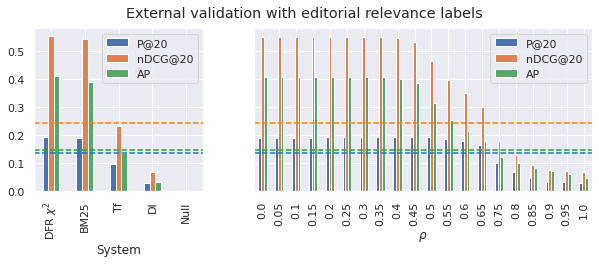

In [5]:
################################################################################
# tripjudge: plot benchmark ####################################################

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")


fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,3), gridspec_kw={'width_ratios': [1, 2]})

df = pd.read_csv('./revision/experimental_results/benchmark.exp.tripjudge.2.grade.csv')

_p20 = df[df['name'] == 'Baseline']['P_20'].iloc[0]
_ndcg20 = df[df['name'] == 'Baseline']['ndcg_cut_20'].iloc[0]
_map = df[df['name'] == 'Baseline']['map'].iloc[0]

df = df[df['name'] != 'Baseline']
df = df.replace('Baseline', 'Base')
df = df.replace('X^2', 'DFR $\chi^2$')
df.sort_values(by='P_20', ascending=False).plot.bar(x='name', ax=axes[0])
plt.ylabel('Score')
axes[0].set_xlabel('System')
axes[0].legend(['P@20', 'nDCG@20', 'AP'])
axes[0].axhline(_p20, ls='--', color='tab:blue')
axes[0].axhline(_ndcg20, ls='--', color='tab:orange')
axes[0].axhline(_map, ls='--', color='tab:green')

df = pd.read_csv('./revision/experimental_results/benchmark.dfree.tripjudge.2.grade.csv')
df = df[df['name'] != 0.7]
df.plot.bar(x='name', ax=axes[1])
plt.ylabel('Score')
axes[1].set_xlabel(r'$\rho$')
axes[1].legend(['P@20', 'nDCG@20', 'AP'])
axes[1].axhline(_p20, ls='--', color='tab:blue')
axes[1].axhline(_ndcg20, ls='--', color='tab:orange')
axes[1].axhline(_map, ls='--', color='tab:green')

plt.suptitle('External validation with editorial relevance labels')
plt.savefig('./revision/experimental_results/figures/benchmarks.tripjudge.pdf', format='pdf', bbox_inches='tight')

## SPECTER-based rerankings

In [ ]:
!pip install python-terrier
!pip install --upgrade git+https://github.com/terrierteam/pyterrier_t5.git
!pip install --upgrade git+https://github.com/terrierteam/pyterrier_colbert.git
!pip install --upgrade git+https://github.com/terrierteam/pyterrier_dr.git
!pip install faiss-gpu
!pip install ranx
!pip install -U adapter-transformers

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import euclidean_distances

import ir_datasets

import pyterrier as pt
import pandas as pd
if not pt.started():
  pt.init()

from ranx import Run

tokenizer = AutoTokenizer.from_pretrained('allenai/specter2')

model_query = AutoModel.from_pretrained('allenai/specter2')
model_query.load_adapter("allenai/specter2_adhoc_query", source="hf", load_as="adhoc_query", set_active=True)

model_prox = AutoModel.from_pretrained('allenai/specter2')
model_prox.load_adapter("allenai/specter2_proximity", source="hf", load_as="proximity", set_active=True)

device = torch.device('cuda')

model_query.to(device)
model_prox.to(device)

dataset = ir_datasets.load("tripclick")
docstore = dataset.docs_store()

dataset = pt.get_dataset('irds:tripclick/test/head')
index = pt.IndexFactory.of('./indices/tripclick/data.properties')
head_queries = pd.read_csv('./experimental_results/train.head.50.csv')

k = 800

BM25 = pt.BatchRetrieve(index, wmodel="BM25") % k
BM25_res = BM25(head_queries)
pt.io.write_results(BM25_res, 'bm25', format='trec', append=False, run_name='BM25')

_run = {}

cnt = 1

for qid in BM25_res['qid'].unique():
  query = head_queries[head_queries['qid'] == qid]['query'].iloc[0]
  # query = dataset.get_topics()[dataset.get_topics()['qid'] == qid]['query'].iloc[0]
  print(cnt)

  inputs = tokenizer([query],
                      padding=True,
                      truncation=True,
                      return_tensors="pt",
                      return_token_type_ids=False,
                      max_length=512).to(device)
  output = model_query(**inputs)
  embedding_query = output.last_hidden_state[:, 0, :]
  embedding_query = embedding_query.cpu().detach().numpy()

  _ranking = {}
  docnos = BM25_res[BM25_res['qid'] == qid]['docno']

  for i in range(0, len(docnos), 10):
    chunk = docnos[i:i + 10]

    text_batch = [docstore.get(doc).title + tokenizer.sep_token + (docstore.get(doc).text or '') for doc in chunk]

  # text_batch = [docstore.get(doc).title + tokenizer.sep_token + (docstore.get(doc).text or '') for doc in docnos]

    inputs = tokenizer(text_batch,
                      padding=True,
                      truncation=True,
                      return_tensors="pt",
                      return_token_type_ids=False,
                      max_length=512).to(device)
    output = model_prox(**inputs)
    embedding_texts = output.last_hidden_state[:, 0, :]

    embedding_texts = embedding_texts.cpu().detach().numpy()

    scores = euclidean_distances(embedding_query, embedding_texts).flatten()

    # for docno, score in zip(docnos, scores):
    for docno, score in zip(chunk, scores):
      _ranking[str(docno)] = float(-score)

  _run[qid] = _ranking
  cnt+=1

r = Run.from_dict(_run)
r.save('specter.' + str(k), kind='trec')

## Simulated interleaving experiments with SPECTER rerankings

In [ ]:
import pyterrier as pt
import pandas as pd
if not pt.started():
  pt.init()

trials = 10

k = 50
df_data = []
baseline = pt.io.read_results("./revision/runs/head/lrm/BM25.head")
head_queries = pd.read_csv('./experimental_results/train.head.50.csv')

cutoffs = [20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
alphas = [.0, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95, 1]

systems = [
    pt.io.read_results('./revision/runs/head/transformer/specter.' + str(cutoff)) for cutoff in cutoffs
]

cm = 'dctr' # cm = 'dctr','dcm', 'sdbn'

for cm in ['dctr', 'dcm', 'sdbn']:
    click_model = globals()[cm.upper()]()

    for sessions in range(100, 101):
        for trial in range(1, trials + 1):

            # load click model
            f_name = '.'.join([cm, str(sessions), str(trial), 'json'])
            path_in = os.path.join('experimental_results', cm, f_name)
            with open(path_in, 'r') as f_in:
                json_str = f_in.read()
                click_model.from_json(json_str)
                
            # determine probabilites for unknown items to identify an indifferent click decision for ties
            _unk = TaskCentricSearchSession('0', head_queries['query'].iloc[0])
            for i in range(1,21):
                _result = SearchResult('.'.join(['UNK', str(i)]), 0)
                _unk.web_results.append(_result)
            _unk_probs = click_model.get_conditional_click_probs(_unk)

            for exp_sys, cutoff in zip(systems, cutoffs):
            # for exp_sys, alpha in zip(systems, alphas):
            
                wins = 0
                ties = 0
                results = []
                        
                # for query in queries['query']:
                for qid, query in zip(head_queries['qid'], head_queries['query']):

                    res_base = baseline[baseline['qid'] == str(qid)]
                    res_exp = exp_sys[exp_sys['qid'] == str(qid)]
                    tdi = interleave(list(res_base['docno']), list(res_exp['docno']))
            
                    ## determine win by max criterion
                    cnt = 0
                    _session = TaskCentricSearchSession('0', query)
                    
                    for item in tdi.values():
                        if cnt < 20:
                            result = item.get('docid')
                            _result = SearchResult(result, 0)
                            _session.web_results.append(_result)
                            cnt += 1
                
                    _probs = click_model.get_full_click_probs(_session)
                    
                    if _unk_probs == _probs:
                        ties += 1
                        results.append(0)
                        continue
     
                    val = max(_probs)
                    idx = _probs.index(val) + 1
                    
                    if tdi.get(idx).get('type') == 'EXP':
                        wins += 1
                        results.append(1)
                    else:
                        results.append(-1)
            
                # determine outcome according to wins / (wins + losses)
                outcome = wins / (len(head_queries['query']) - ties)
                
                df_data.append({'cutoff': cutoff,
                                'sessions': sessions,
                                'trial': trial,
                                'outcome': outcome})

                print("Queries:", str(k), "\tClick model:", cm, "\tCutoff:", str(cutoff), "\tSessions:", str(sessions),"\tTrial:", str(trial) ,"\tOutcome:", outcome)  

    f_out_name = './revision/experimental_results/' + cm + '.outcome.specter.cutoff.' + str(k) + '.csv'

    pd.DataFrame(df_data).to_csv(f_out_name, index=False)

## Evaluation of SPECTER outcomes

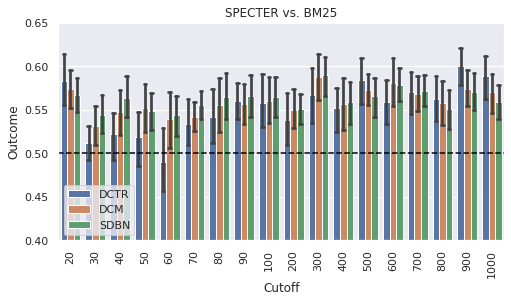

In [4]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()

df_data = []

cm = ['dctr', 'dcm', 'sdbn']
# cm = ['sdbn']

for model_name in cm:
    k = 50
    df = pd.read_csv('./revision/experimental_results/' + model_name + '.outcome.specter.cutoff.' + str(k) + '.csv')
    # df = df[df['system'] != 'Baseline']
    _s = 100
    t = 10
    for _t in range(1, t+1):
        for row in df[(df['sessions'] == _s) & (df['trial'] == _t)].iterrows():
            df_data.append({
                'cm': model_name,
                'cutoff': int(row[1].cutoff),
                'trial': _t,
                'outcome': row[1].outcome
            })

_df = pd.DataFrame(df_data)
plt.figure(figsize=(8,4))
ax = sns.barplot(x="cutoff", y="outcome", hue="cm", data=_df, capsize=.1)
ax.set(ylim=(.4, .65))
ax.set(xlabel='Cutoff')
ax.set(ylabel='Outcome')
ax.set_title('SPECTER vs. BM25')
ax.tick_params(axis='x', labelrotation = 90)
# ax.set_xlabel('Cutoff')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=[l.upper() for l in labels])
ax.axhline(0.5, ls='--', color='black')
# axes[1].legend(handles=handles, labels=[l.upper() for l in labels])
plt.savefig('./revision/experimental_results/figures/specter.outcomes.pdf', format='pdf', bbox_inches='tight')
plt.show()

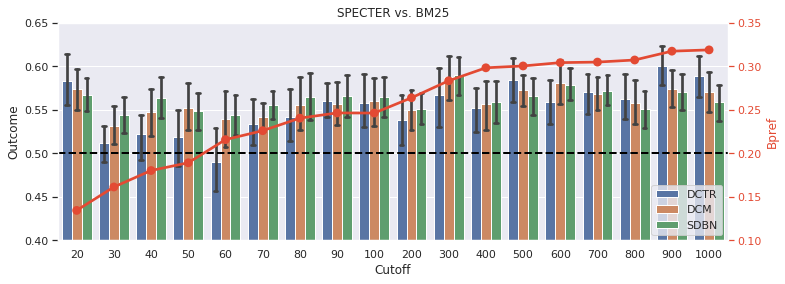

In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()

df_data = []

cm = ['dctr', 'dcm', 'sdbn']

for model_name in cm:
    k = 50
    df = pd.read_csv('./revision/experimental_results/' + model_name + '.outcome.specter.cutoff.' + str(k) + '.csv')
    # df = df[df['system'] != 'Baseline']
    _s = 100
    t = 10
    for _t in range(1, t+1):
        for row in df[(df['sessions'] == _s) & (df['trial'] == _t)].iterrows():
            df_data.append({
                'cm': model_name,
                'cutoff': int(row[1].cutoff),
                'trial': _t,
                'outcome': row[1].outcome
            })


_df = pd.DataFrame(df_data)

# plt.figure(figsize=(12,4))
fig, ax1 = plt.subplots(figsize=(12,4))
# ax2 = ax1.twinx()
df_bpref = pd.read_csv('./revision/experimental_results/specter.bpref.csv')
ax = sns.barplot(x="cutoff", y="outcome", hue="cm", data=_df, capsize=.1, ax=ax1)
ax2 = ax1.twinx()
sns.pointplot(x='cutoff', y='bpref', color='#e34a33', data=df_bpref, ax=ax2)

ax1.set(ylim=(.4, .65))
ax2.set(ylim=(.1, .35))
ax2.grid(False)
ax.set(xlabel='Cutoff')
ax1.set(ylabel='Outcome')
ax2.set(ylabel='Bpref')
ax2.yaxis.label.set_color('#e34a33')
ax2.tick_params(axis='y', colors='#e34a33')
ax.set_title('SPECTER vs. BM25')
handles, labels = ax1.get_legend_handles_labels()
ax.legend(handles=handles, labels=[l.upper() for l in labels], loc='lower right')
ax.axhline(0.5, ls='--', color='black', linewidth=2)
plt.savefig('./revision/experimental_results/figures/specter.cutoffs.pdf', format='pdf', bbox_inches='tight')
plt.show()

## RBO vs. Bpref analysis

In [ ]:
import pyterrier as pt
import pandas as pd
if not pt.started():
  pt.init()

def _rbo(run, ideal, p, depth):
    # Implementation taken from the TREC Health Misinformation Track with modifications
    # see also: https://github.com/claclark/Compatibility
    run_set = set()
    ideal_set = set()

    score = 0.0
    normalizer = 0.0
    weight = 1.0
    for i in range(depth):
        if i < len(run):
            run_set.add(run[i])
        if i < len(ideal):
            ideal_set.add(ideal[i])
        score += weight*len(ideal_set.intersection(run_set))/(i + 1)
        normalizer += weight
        weight *= p
    return score/normalizer


df_data = []

base = list(baseline[baseline['qid'] == '1546366']['docno'][:20])
specter = list(systems[0][systems[0]['qid'] == '1546366']['docno'][:20])
_rbo(specter, base, 0.95, 20)


qids = baseline['qid'].unique()
cutoffs = [20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

for cutoff in cutoffs:
    
    rbo_scores = []
    specter_run = pt.io.read_results('./revision/runs/head/transformer/specter.' + str(cutoff)) 


    for qid in qids:
        base = list(baseline[baseline['qid'] == qid]['docno'][:20])
        specter = list(specter_run[specter_run['qid'] == qid]['docno'][:20])
        rbo = _rbo(specter, base, 0.99, 20)
        rbo_scores.append(rbo)
        
    rbo_avg = sum(rbo_scores) / len(rbo_scores)
    
    print('Cutoff: ', str(cutoff), 'RBO: ', rbo_avg)
    df_data.append({'cutoff': cutoff, 'rbo': rbo_avg})
    
pd.DataFrame(df_data).to_csv('./revision/experimental_results/specter.rbo.csv', index=False)


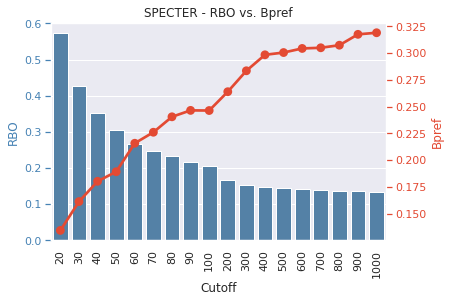

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()

fig, ax1 = plt.subplots(figsize=(6,4))
df_bpref = pd.read_csv('./revision/experimental_results/specter.bpref.csv')
df_rbo = pd.read_csv('./revision/experimental_results/specter.rbo.csv')

ax = sns.barplot(x="cutoff", y="rbo", data=df_rbo, capsize=.1, color='steelblue', ax=ax1)
ax2 = ax1.twinx()
sns.pointplot(x='cutoff', y='bpref', color='#e34a33', data=df_bpref, ax=ax2)
ax2.grid(False)
ax1.set(ylabel='RBO')
ax1.yaxis.label.set_color('steelblue')
ax1.tick_params(axis='y', colors='steelblue')

ax2.set(ylabel='Bpref')
ax2.yaxis.label.set_color('#e34a33')
ax2.tick_params(axis='y', colors='#e34a33')
ax.set_title('SPECTER - RBO vs. Bpref')
ax.tick_params(axis='x', labelrotation = 90)
ax.set_xlabel('Cutoff')
plt.savefig('./revision/experimental_results/figures/specter.rbo.bpref.pdf', format='pdf', bbox_inches='tight')
plt.show()